In [ ]:
#!pip install tweepy
#!pip install snscrape
#!pip install selenium

## Importing Libraries 

In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
consumer_key = "QWdm8hkp0Yvzr9RUnPoImHSAf"
consumer_secret = "shW1tXTrlZ5WS5z4URuYVrHUcgMuOL2XkQ8wKli9xtk1bjFRiJ"
access_token = "303697285-5teaR6YGuJ1VE2Uq9BTyLQ3UUJ3PX6Ziv8PsGCHA"
access_token_secret = "TkeHGoXUw9SHS9lgAgMm7jSO9RO1gmTLdDvADyLqdwp2n"
#from api_access import api
import tweepy
#import re
from operator import itemgetter

In [5]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [6]:
api

In [7]:
import nltk
from nltk.corpus import stopwords
stop_nltk = stopwords.words("english")
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Extracting Twitter Comments

In [8]:
def get_tweet_ids(keyword,period,startDate,endDate,maxTweets):
    
    '''
    Function to scrape tweet ids for a given hashtag using snscrape
    '''
    f = os.system('snscrape --max-results '+str(maxTweets)+' twitter-hashtag '+'"'+keyword+' since:'+startDate+' until:'+endDate+'"'+' >fetched_tweet_ids_'+period+'_#'+keyword+'.txt')
    if f==0:
        print(f"Successfully fetched tweet ids for #{keyword}")

In [9]:
def fetch_tw(ids,keyword,period):
    
    '''
    Function to extract tweet attributes - id, text, date, hashtags, usermentions
    '''
    list_of_tw_status = api.statuses_lookup(id_=ids,tweet_mode="extended") #ids batch size limited to 100
    #time.sleep(5)
    empty_data = pd.DataFrame()
    
    for status in list_of_tw_status:
        
        if status.lang=='en': #getting only tweets in english
        
            #if str(status.created_at).split(' ')[0]>'2019-12-17':
                
            try:
                hashtags = list(map(itemgetter('text'),status.entities['hashtags'])) 
            except:
                hashtags=None
            try:
                user_mentions=status.entities['user_mentions'][0]['screen_name']
            except:
                user_mentions=None
                    
            tweet_elem = {"id":status.id,
                          "date":status.created_at,
                          "tweet":status.full_text,
                          "hashtags":str(hashtags).strip('[]'),
                          "usermentions":user_mentions}
            
        else:
            continue
        
        empty_data = empty_data.append(tweet_elem,ignore_index=True)
            
    empty_data.to_csv("fetched_tweets_"+period+'_#'+keyword+".csv", mode="a",index=False)

In [10]:
def get_tweets(keyword,period):
    
    '''
    Function to get tweet data using tweet ids
    '''
 
    #Extracting ids from the tweet urls
    tweet_url = pd.read_csv("fetched_tweet_ids_"+period+"_#"+keyword+".txt", index_col= None, header = None, names = ["links"])
    af = lambda x: x["links"].split("/")[-1]
    tweet_url['id'] = tweet_url.apply(af, axis=1)
    ids = tweet_url['id'].tolist()
    
    # Processing the ids in batches
    total_count = len(ids)
    chunks = (total_count - 1) // 50 + 1
    for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch,keyword,period)
        print(f'Batch {i+1} processed successfully...')

In [12]:
def get_processed_tweets(keywords,period,startDate,endDate,maxTweets):

    '''
    Function to get processed tweets
    '''
    
    # Importing dependent functions
    
    for keyword in keywords:
        
        get_tweet_ids(keyword,period,startDate,endDate,maxTweets)

        get_tweets(keyword,period)
        
    # Merging all records from csv files of different hashtags
    
    tweets = []
    
    for keyword in keywords:
    
        df = pd.read_csv('fetched_tweets_'+period+'_#'+keyword+'.csv',index_col=None,header=0)
        tweets.append(df)
        
    tweet_data = pd.concat(tweets,axis=0,ignore_index=True)
    
    tweet_data.columns = ['Date_time','Hashtags','ID','Tweet_text','Usermentions'] # Naming columns

    # Removing repetitive headers
    indices = tweet_data[tweet_data['Tweet_text']=='tweet'].index
    tweet_data.drop(indices,inplace=True)
    
    # Removing duplicate records keeping the first one
    tweet_data.drop_duplicates("ID",inplace=True)

    # Converting to datetime object
    tweet_data['Date'] = tweet_data['Date_time'].str.split(" ",expand=True)[0]
    tweet_data = tweet_data.drop(['Date_time'],axis=1)
    tweet_data['Date'] = pd.to_datetime(tweet_data['Date'],infer_datetime_format=True)
    
    # Removing rows that fall outside of the date range
    tweet_data = tweet_data[(tweet_data['Date']>=startDate) & (tweet_data['Date']<=endDate)]
    
    # Converting IDs to integers
    tweet_data['ID'] = [int(float(i)) for i in tweet_data['ID'].to_list()] # Conversion from scientific to integer notation

    # Rearranging columns
    tweet_data = tweet_data[['ID','Date','Tweet_text','Hashtags','Usermentions']]
    
    # Sorting rows based on date
    tweet_data.sort_values(ascending=False, by="Date",inplace=True)

    return tweet_data

**Pre-Covid Period: Jul 1,2019 to Feb 29,2020** <br> **Post-covid Period: Mar 1,2020 to Present**

In [17]:
# List of hashtags to search (equivalent to 'OR')
keywords = ['TVSMotor','tvsapache','tvsstarcity','tvsjupiter']

periods = ['precovid','postcovid']
dates = ['2019-07-01','2020-02-29','2020-03-01',str(datetime.date.today())]
maxTweets = 100000

In [18]:
pre_covid_tweets = get_processed_tweets(keywords,periods[0],dates[0],dates[1],maxTweets)

Successfully fetched tweet ids for #TVSMotor
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Successfully fetched tweet ids for #tvsapache
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Successfully f

In [19]:
post_covid_tweets = get_processed_tweets(keywords,periods[1],dates[2],dates[3],maxTweets)

Successfully fetched tweet ids for #TVSMotor
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Batch 21 processed successfully...
Batch 22 processed successfully...
Batch 23 processed successfully...
Batch 24 processed successfully...
Batch 25 processed successfully...
Batch 26 processed successfully...
Batch 27 processed successfully...
Batch 28 processed 

In [20]:
pre_covid_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
25,1233272568154476544,2020-02-28,#TVSMotor\n\nAnnounced their partnership with ...,"'TVSMotor', 'MotomundoSA'",NaN
8,1232926396407660544,2020-02-27,"#TVSMotor W, tight sqeeze expecting some big m...",'TVSMotor',NaN
21,1232877295796285440,2020-02-27,"TVS Motor Company, announced their partnership...","'Honduras', 'Motomundo', 'TVSMotor'",NaN
2555,1232985847693053952,2020-02-27,"Hey guys, check out some benefits of buying TV...","'TVSJupiter', 'TVSMotors', 'Scooter'",NaN
2148,1232971505526431744,2020-02-27,One gorgeous machine 😍\n#apacherr310 #bs6 #tvs...,"'apacherr310', 'bs6', 'tvsapache', 'dreammachine'",NaN
...,...,...,...,...,...
711,1145921724430422016,2019-07-02,#CorporateNews #ArihantCapital #TVSMOTOR TVS M...,"'CorporateNews', 'ArihantCapital', 'TVSMOTOR'",NaN
708,1146141476398616576,2019-07-02,LONG TVSMOTOR - #TVSMOTOR chart https://t.co/s...,'TVSMOTOR',NaN
707,1145862149354319872,2019-07-02,#TVSMOTOR - [Positional] TVS Motors Swing Bet ...,'TVSMOTOR',NaN
704,1145591590406148096,2019-07-01,#TVSMOTOR chart https://t.co/hFGvsns2ar \nTarg...,'TVSMOTOR',NaN


In [21]:
post_covid_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
18,1339459453762949120,2020-12-17,TVS Motor Target hit. Day High 500.05 #TVSMOTO...,'TVSMOTOR',NaN
38,1339472031792959488,2020-12-17,#tvsmotor at 500+ again #hporb https://t.co/98...,"'tvsmotor', 'hporb'",NaN
42,1339091542200311808,2020-12-16,TVS Motor India's Best Two Wheeler Company.\n#...,"'TVSMotor', 'tvscompany'",NaN
13,1339093782373920768,2020-12-16,TVS Motor Best Two Wheeler Company in India of...,"'TVSMotor', 'tvscompany'",NaN
3,1339090153529229312,2020-12-16,TVS Radeon is the best Commuter Bike in India ...,"'TVSRadeon', 'TVSMotor', 'tvscompany'",NaN
...,...,...,...,...,...
1282,1234332283668254720,2020-03-02,BUY #TVSMOTOR MAR FUT BETWEEN 425 to 426 SL 42...,"'TVSMOTOR', 'StocksToTrade', 'NIFTY', 'BankNifty'",NaN
1286,1234532158544367616,2020-03-02,"According to #TVSMotor, it is on track to redu...","'TVSMotor', 'AutoSales'",NaN
1280,1234374470262910976,2020-03-02,Feb #AutoSales | #TVSMotor reports total sales...,"'AutoSales', 'TVSMotor', 'Coronavirus'",NaN
1276,1234381757350178816,2020-03-02,#Maruti - flat - as dealer inventory and retai...,"'Maruti', 'TVSMotor', 'BajajAuto', 'Escorts', ...",TargetInvesting


## Text Processing 

In [26]:
stop_updated = stop_nltk + ["tvsmotor","tvs motor ","tvs apache","bike","motorcycle","biker",
                "bikes","motorcycles","tvs starcity","jupiter","tvscompany","apacherr310","tvsapache","re"]

stemmer_s = SnowballStemmer("english")

In [29]:
import re

In [30]:
# Use https://www.regexpal.com/ to test regular expressions

def clean_text(line):
    
    '''
    Function to clean text
    '''
    # Removing links,special characters, etc. using regular expressions
    text = re.sub("#[A-Za-z0-9]+"," ",line) # Removing hashtags first
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",text)
    tokens = text.lower().strip().split()  #strip() removes white spaces before and after the text
    stemmed = [stemmer_s.stem(term) for term in tokens \
               if term not in stop_updated and \
               len(term)>2]
    return ' '.join(stemmed)

In [31]:
pre_covid_tweets['Cleaned_text'] = pre_covid_tweets['Tweet_text'].apply(clean_text)
pre_covid_tweets[['Date','Tweet_text','Cleaned_text']]

,Date,Tweet_text,Cleaned_text
25,2020-02-28,#TVSMotor\n\nAnnounced their partnership with ...,announc partnership one largest respect busi g...
8,2020-02-27,"#TVSMotor W, tight sqeeze expecting some big m...",tight sqeez expect big move either side next m...
21,2020-02-27,"TVS Motor Company, announced their partnership...",tvs motor compani announc partnership motomund...
2555,2020-02-27,"Hey guys, check out some benefits of buying TV...",hey guy check benefit buy tvs
2148,2020-02-27,One gorgeous machine 😍\n#apacherr310 #bs6 #tvs...,one gorgeous machin tvs ntorq
...,...,...,...
711,2019-07-02,#CorporateNews #ArihantCapital #TVSMOTOR TVS M...,tvs motor regist sale 297 102 unit june 2019
708,2019-07-02,LONG TVSMOTOR - #TVSMOTOR chart https://t.co/s...,long chart
707,2019-07-02,#TVSMOTOR - [Positional] TVS Motors Swing Bet ...,posit tvs motor swing bet tradingview
704,2019-07-01,#TVSMOTOR chart https://t.co/hFGvsns2ar \nTarg...,chart target 470


In [32]:
post_covid_tweets['Cleaned_text'] = post_covid_tweets['Tweet_text'].apply(clean_text)
post_covid_tweets[['Date','Tweet_text','Cleaned_text']]

,Date,Tweet_text,Cleaned_text
18,2020-12-17,TVS Motor Target hit. Day High 500.05 #TVSMOTO...,tvs motor target hit day high 500
38,2020-12-17,#tvsmotor at 500+ again #hporb https://t.co/98...,500
42,2020-12-16,TVS Motor India's Best Two Wheeler Company.\n#...,tvs motor india best two wheeler compani
13,2020-12-16,TVS Motor Best Two Wheeler Company in India of...,tvs motor best two wheeler compani india offer...
3,2020-12-16,TVS Radeon is the best Commuter Bike in India ...,tvs radeon best commut india bigger wheel usb ...
...,...,...,...
1282,2020-03-02,BUY #TVSMOTOR MAR FUT BETWEEN 425 to 426 SL 42...,buy mar fut 425 426 422 tgt open join free gro...
1286,2020-03-02,"According to #TVSMotor, it is on track to redu...",accord track reduc dealer level stock domest m...
1280,2020-03-02,Feb #AutoSales | #TVSMotor reports total sales...,feb report total sale lakh unit nomura expect ...
1276,2020-03-02,#Maruti - flat - as dealer inventory and retai...,flat dealer inventori retail sale better decli...


In [35]:
all_tweets = pd.concat([pre_covid_tweets,post_covid_tweets])
all_tweets.sort_values(ascending=False, by="Date",inplace=True)
all_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions,Cleaned_text
38,1339472031792959488,2020-12-17,#tvsmotor at 500+ again #hporb https://t.co/98...,"'tvsmotor', 'hporb'",NaN,500
18,1339459453762949120,2020-12-17,TVS Motor Target hit. Day High 500.05 #TVSMOTO...,'TVSMOTOR',NaN,tvs motor target hit day high 500
42,1339091542200311808,2020-12-16,TVS Motor India's Best Two Wheeler Company.\n#...,"'TVSMotor', 'tvscompany'",NaN,tvs motor india best two wheeler compani
3,1339090153529229312,2020-12-16,TVS Radeon is the best Commuter Bike in India ...,"'TVSRadeon', 'TVSMotor', 'tvscompany'",NaN,tvs radeon best commut india bigger wheel usb ...
1331,1339172889732341760,2020-12-16,TVS Apache RTR 4V BS6 specs .Review soon on o...,"'tvs', 'tvsracing', 'tvsapache', 'apache1604v'...",NaN,tvs apach rtr bs6 spec review soon youtub chan...
...,...,...,...,...,...,...
705,1146141490088775680,2019-07-02,#TVSMOTOR - LONG TVSMOTOR - TradingView - http...,'TVSMOTOR',NaN,long tradingview
713,1146079136487596032,2019-07-02,@tvsmotorcompany It has been 2 days since I ha...,'tvsmotor',tvsmotorcompany,day sinc regist complaint via email got respon...
714,1145935359714484224,2019-07-02,Congratulations to all the winners who gave ou...,"'TVSNTORQ125', 'TVSMOTOR', 'Contest', 'Winners...",NaN,congratul winner gave new matt silver coolest ...
704,1145591590406148096,2019-07-01,#TVSMOTOR chart https://t.co/hFGvsns2ar \nTarg...,'TVSMOTOR',NaN,chart target 470


## Extracting tweets of official twitter handle 

In [36]:
def get_tweet_ids1(keyword,period,startDate,endDate,maxTweets):
    
    '''
    Function to scrape tweet ids for a given hashtag using snscrape
    '''
    f = os.system('snscrape --max-results '+str(maxTweets)+' twitter-user '+'"'+keyword+' since:'+startDate+' until:'+endDate+'"'+' >fetched_tweet_ids_'+period+'_@'+keyword+'.txt')
    if f==0:
        print(f"Successfully fetched tweet ids for @{keyword}")

In [37]:
def fetch_tw1(ids,keyword,period):
    
    '''
    Function to extract tweet attributes - id, text, date, hashtags, usermentions
    '''
    list_of_tw_status = api.statuses_lookup(id_=ids,tweet_mode="extended") #ids batch size limited to 100
    #time.sleep(5)
    empty_data = pd.DataFrame()
    
    for status in list_of_tw_status:
        
        if status.lang=='en': #getting only tweets in english
        
            #if str(status.created_at).split(' ')[0]>'2019-12-17':
                
            try:
                hashtags = list(map(itemgetter('text'),status.entities['hashtags'])) 
            except:
                hashtags=None
            try:
                user_mentions=status.entities['user_mentions'][0]['screen_name']
            except:
                user_mentions=None
                    
            tweet_elem = {"id":status.id,
                          "date":status.created_at,
                          "tweet":status.full_text,
                          "hashtags":str(hashtags).strip('[]'),
                          "usermentions":user_mentions}
            
        else:
            continue
        
        empty_data = empty_data.append(tweet_elem,ignore_index=True)
            
    empty_data.to_csv("fetched_tweets_"+period+'_@'+keyword+".csv", mode="a",index=False)

In [38]:
def get_tweets1(keyword,period):
    
    '''
    Function to get tweet data using tweet ids
    '''
 
    #Extracting ids from the tweet urls
    tweet_url = pd.read_csv("fetched_tweet_ids_"+period+"_@"+keyword+".txt", index_col= None, header = None, names = ["links"])
    af = lambda x: x["links"].split("/")[-1]
    tweet_url['id'] = tweet_url.apply(af, axis=1)
    ids = tweet_url['id'].tolist()
    
    # Processing the ids in batches
    total_count = len(ids)
    chunks = (total_count - 1) // 50 + 1
    for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw1(batch,keyword,period)
        print(f'Batch {i+1} processed successfully...')

In [39]:
def get_processed_tweets1(keywords,period,startDate,endDate,maxTweets):

    '''
    Function to get processed tweets
    '''
    
    # Importing dependent functions
    
    for keyword in keywords:
        
        get_tweet_ids1(keyword,period,startDate,endDate,maxTweets)

        get_tweets1(keyword,period)
        
    # Merging all records from csv files of different hashtags
    
    tweets = []
    
    for keyword in keywords:
    
        df = pd.read_csv('fetched_tweets_'+period+'_@'+keyword+'.csv',index_col=None,header=0)
        tweets.append(df)
        
    tweet_data = pd.concat(tweets,axis=0,ignore_index=True)
    
    tweet_data.columns = ['Date_time','Hashtags','ID','Tweet_text','Usermentions'] # Naming columns

    # Removing repetitive headers
    indices = tweet_data[tweet_data['Tweet_text']=='tweet'].index
    tweet_data.drop(indices,inplace=True)
    
    # Removing duplicate records keeping the first one
    tweet_data.drop_duplicates("ID",inplace=True)

    # Converting to datetime object
    tweet_data['Date'] = tweet_data['Date_time'].str.split(" ",expand=True)[0]
    tweet_data = tweet_data.drop(['Date_time'],axis=1)
    tweet_data['Date'] = pd.to_datetime(tweet_data['Date'],infer_datetime_format=True)
    
    # Removing rows that fall outside of the date range
    tweet_data = tweet_data[(tweet_data['Date']>=startDate) & (tweet_data['Date']<=endDate)]
    
    # Converting IDs to integers
    tweet_data['ID'] = [int(float(i)) for i in tweet_data['ID'].to_list()] # Conversion from scientific to integer notation

    # Rearranging columns
    tweet_data = tweet_data[['ID','Date','Tweet_text','Hashtags','Usermentions']]
    
    # Sorting rows based on date
    tweet_data.sort_values(ascending=False, by="Date",inplace=True)

    return tweet_data

In [7]:
'''
FINAL DATASETS

pre_covid_tweets
post_covid_tweets

'''

# Exporting the processed data to csv files

pre_covid_tweets.to_csv(r'pre_covid_tweets.csv', index = False)
post_covid_tweets.to_csv(r'post_covid_tweets.csv', index = False)


NameError: name 'pre_covid_tweets' is not defined

## Exploratory Data Analysis 

In [46]:
data = [[pre_covid_tweets.shape[0]],[post_covid_tweets.shape[0]]]

IndexError: list index out of range

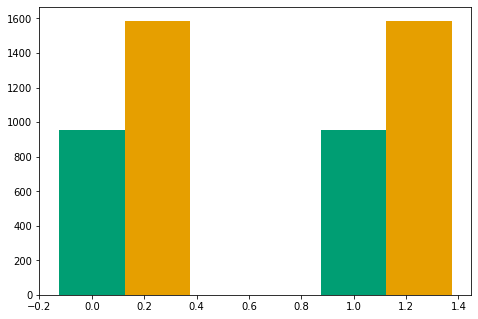

In [48]:
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = '#009E73', width = 0.25, label='Total')
ax.bar(X + 0.25, data[1], color = '#E69F00', width = 0.25, label='Pre-covid')
ax.bar(X + 0.50, data[2], color = '#56B4E9', width = 0.25, label='Post-covid')

ax.set_title('COMPLETE DATA SET',fontsize=15)
plt.xlabel('Data Source')
plt.ylabel('Count')
plt.xticks(X+0.25,['Tweets'])
plt.legend(loc="upper right")

rects = ax.patches

labels = [item for sublist in data for item in sublist] # converting list of list to a list

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

In [49]:
#!pip install plotly
#!pip install cufflinks

In [3]:
# References

#https://library.iimidr.ac.in:2054/science/article/pii/S0736585317304999
#http://web.quant-platform.com/trial/yves/Plotly_Cufflinks.html
#https://scentellegher.github.io/programming/2017/07/15/pandas-groupby-multiple-columns-plot.html
#https://towardsdatascience.com/analysis-of-tweets-on-the-hong-kong-protest-movement-2019-with-python-a331851f061

import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

ModuleNotFoundError: No module named 'cufflinks'

In [5]:
import pandas as pd

In [6]:
all_tweets_time = pd.concat([pre_covid_tweets,post_covid_tweets])


NameError: name 'pre_covid_tweets' is not defined

In [ ]:
daily_count = pd.concat([all_tweets_time.groupby('Date').count()['ID']],axis=1)
daily_count.columns = ['Tweet Count']
annotations = {'2020-11-06':'RE Meteor Launch'}
daily_count.iplot(title='DAILY COUNT',theme='white')

In [58]:
all_yt_comments_time['Date']=pd.to_datetime(all_yt_comments_time['Date'],infer_datetime_format=True)
monthly_count = pd.concat([all_tweets_time.groupby(all_tweets_time.Date.dt.to_period("M")).count()["ID"],all_yt_comments_time.groupby(all_yt_comments_time.Date.dt.to_period("M")).count()["Comment ID"]],axis=1)
monthly_count.columns = ['Tweet Count','Comment Count']
monthly_count.iplot(title='MONTHLY COUNT',theme='white')

### Tweet Hashtag Analysis

In [57]:
all_tweets_time = all_tweets_time.reset_index(drop=True) # Resetting index
split_data = all_tweets_time['Hashtags'].str.split(', ')
split_data.dropna(inplace=True)
split_data = split_data.reset_index(drop=True) # Dropping NaN values and resetting index

In [58]:
tags = []

for row in range(len(split_data)):
    tags.extend(split_data[row])
    
hashtags = [tag[1:-1] for tag in tags]

In [59]:
hashtags

['TVSMotor',
 'MotomundoSA',
 'TVSMotor',
 'Honduras',
 'Motomundo',
 'TVSMotor',
 'TVSJupiter',
 'TVSMotors',
 'Scooter',
 'apacherr310',
 'bs6',
 'tvsapache',
 'dreammachine',
 'TVSMotor',
 'MotomundoSA',
 'Honduras',
 'TVSMotor',
 'marketingtips',
 'TVSMOTOR',
 'TVSMOTOR',
 'Nifty',
 'nifty50',
 'tvs',
 'tvsmotor',
 'tvsapache',
 'tvsapacherr310',
 'TVSMOTOR',
 'tvs',
 'tvsmotor',
 'electricscooter',
 'tvsiqube',
 'iqube',
 'TVSMotor',
 'coronavirus',
 'latestnews',
 'TVSmotor',
 'ProductionWoes',
 'teamgearless',
 'longride',
 'india',
 'hondadio',
 'hondaactiva',
 'traveller',
 'yamahafascino',
 'heromaestro',
 'tvswego',
 'tvsjupiter',
 'moped',
 'scooter',
 'vespa',
 'hondaaviator',
 'hondascooter',
 'yamaharay',
 'tvsjupiter',
 'riders',
 'hyderabad',
 'safetyfirst',
 'ecofriendly',
 'gopuncuturefree',
 'goodvibes',
 'AxisSecTradeCalls',
 'StockMarket',
 'equities',
 'BuzzingStock',
 'StocktoWatch',
 'TVSMotor',
 'UPI',
 'TVSMOTOR',
 'StocksToTrade',
 'NIFTY',
 'BankNifty',
 'T

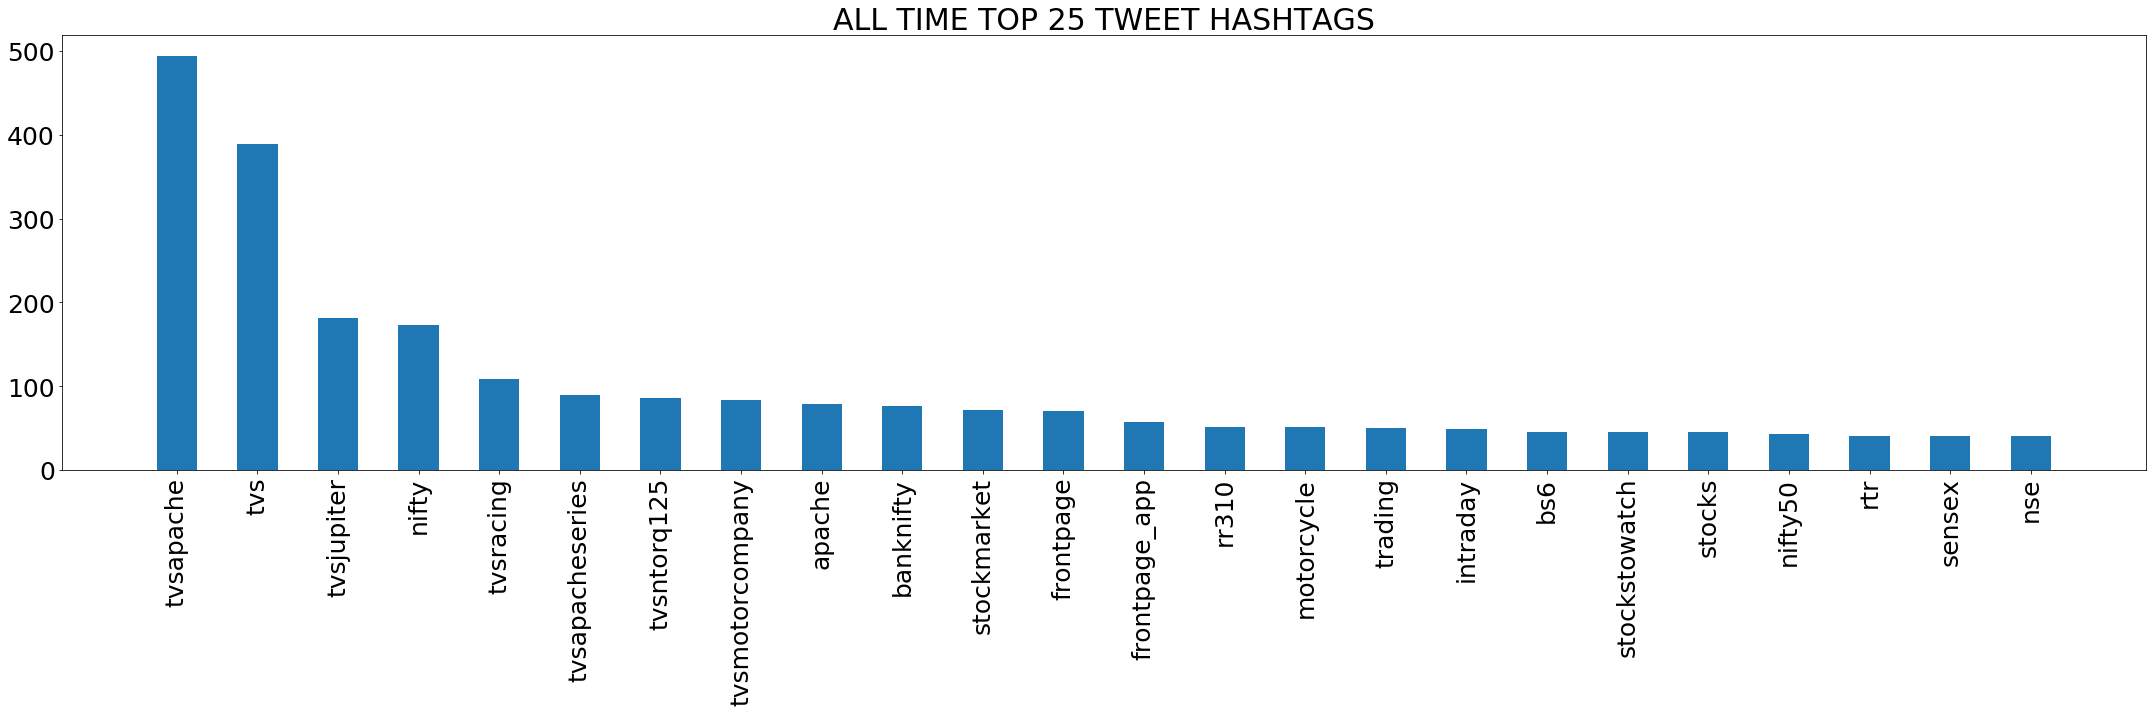

In [60]:
hashtags = [x.lower() for x in hashtags]
freqdists = pd.DataFrame(FreqDist(hashtags).items(), columns = ["words","freq"])
freqdists.sort_values(ascending=False, by="freq",inplace=True)
skipwords = ['royalenfield','motorcycle',]

plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][1:25],freqdists['freq'][1:25],width=0.5) # Excluding royalenfield
plt.title("ALL TIME TOP 25 TWEET HASHTAGS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

In [1]:
# Popular hashtags monthwise

pop_hashtag_month = all_tweets_time[all_tweets_time['Hashtags'].notnull()].groupby(all_tweets_time.Date.dt.to_period("M")).agg({'Hashtags':lambda line: ', '.join(line)})
pop_hashtag_month = pop_hashtag_month.reset_index()

pop_hashtags = []
pop_hashtags_freq = pd.DataFrame()

for item in range(pop_hashtag_month.shape[0]):
    
    tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(1)[0] # eval removes quotes from a string
    
    #if tag in ['tvs','jupiter','apache']: # filtering obvious tags
     #   tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(2)[1] # picking next best
      #  if tag in ['tvs','jupiter','apache']:
       #     tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(3)[2] # picking next best
        
    pop_hashtags.append([tag,count])
    
pop_hashtags_freq = pd.DataFrame(pop_hashtags,columns=['Hashtag','Count'])
pop_hashtags_freq['Date'] = pop_hashtag_month['Date']
pop_hashtags_freq = pop_hashtags_freq[['Date','Hashtag','Count']]

NameError: name 'all_tweets_time' is not defined

In [65]:
pop_hashtags_freq

,Date,Hashtag,Count
0,2019-07,tvsmotor,126
1,2019-08,tvsmotor,72
2,2019-09,tvsmotor,80
3,2019-10,tvsmotor,110
4,2019-11,tvsmotor,83
5,2019-12,tvsmotor,67
6,2020-01,tvsmotor,78
7,2020-02,tvsmotor,77
8,2020-03,tvsmotor,78
9,2020-04,tvsmotor,152


In [2]:
annotations=dict(zip([pop_hashtags_freq['Date'][n].strftime('%Y-%m') for n in range(len(pop_hashtags_freq['Date']))],pop_hashtags_freq['Hashtag']))
pop_hashtags_freq.iplot(kind='bar',x='Date',y='Count',yTitle='Count',theme='white',annotations=annotations,title='MONTHLY TWEET HASHTAG POPULARITY')

NameError: name 'pop_hashtags_freq' is not defined

### Official Twitter Handle Analysis 

#### Market Messaging (using data collected only from official twitter handle) 

In [71]:
# Analysis excludes tweets from users who mentioned @royalenfield

all_off_comp_tweets_time = pd.concat([pre_covid_off_comp_tweets,post_covid_off_comp_tweets])
daily_count = all_off_comp_tweets_time.groupby('Date').count()['ID']
daily_count.columns = ['Tweet Count','Comment Count']
daily_count.iplot(title='DAILY COUNT - COMPANY',theme='white')

In [72]:
all_off_comp_tweets_time = all_off_comp_tweets_time.reset_index(drop=True) # Resetting index
split_data = all_off_comp_tweets_time['Hashtags'].str.split(', ')
split_data.dropna(inplace=True)
split_data = split_data.reset_index(drop=True) # Dropping NaN values and resetting index

In [73]:
tags = []

for row in range(len(split_data)):
    tags.extend(split_data[row])
    
hashtags = [tag[1:-1] for tag in tags]

#### User Response (using data collected only from official twitter handle) 

In [78]:
# Analysis excludes tweets directly from the company

all_off_user_tweets_time = pd.concat([pre_covid_off_user_tweets,post_covid_off_user_tweets])
daily_count = all_off_user_tweets_time.groupby('Date').count()['ID']
daily_count.columns = ['Tweet Count','Comment Count']
daily_count.iplot(title='DAILY COUNT - USER',theme='white')

### Word Clouds

In [85]:
def get_wordcloud(df):
    
    comb_tweets = " ".join(df['Cleaned_text'].values)
    
    wordcloud = WordCloud(width=600,height=600,
                          stopwords=stop_updated,
                          background_color='white',
                          max_words=100,
                          normalize_plurals=True).generate_from_text(comb_tweets)
    
    return wordcloud

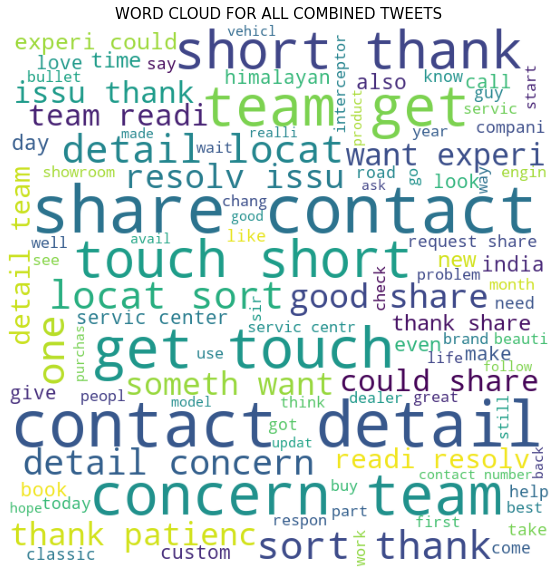

In [86]:
clouds = get_wordcloud(all_tweets)
plt.figure(figsize=(15,10))
plt.title("WORD CLOUD FOR ALL COMBINED TWEETS",fontsize=15)
plt.imshow(clouds)
plt.axis('off')
plt.show()

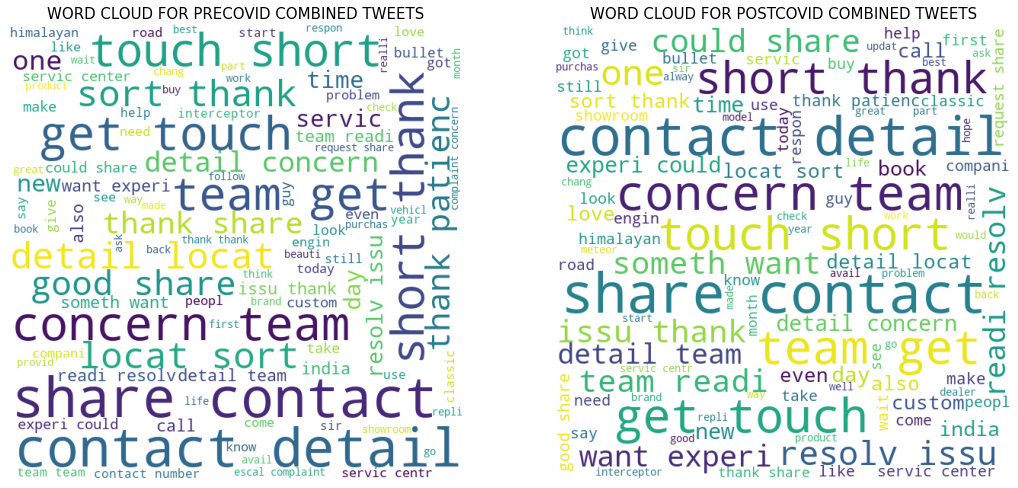

In [87]:
clouds = [get_wordcloud(pre_covid_tweets),get_wordcloud(post_covid_tweets)]
fig,axes = plt.subplots(1,2,figsize=(18,15))
for i in range(len(clouds)):
    axes[i].set_title("WORD CLOUD FOR "+periods[i].upper()+" COMBINED TWEETS",fontsize=15)
    axes[i].imshow(clouds[i])
    axes[i].axis('off')

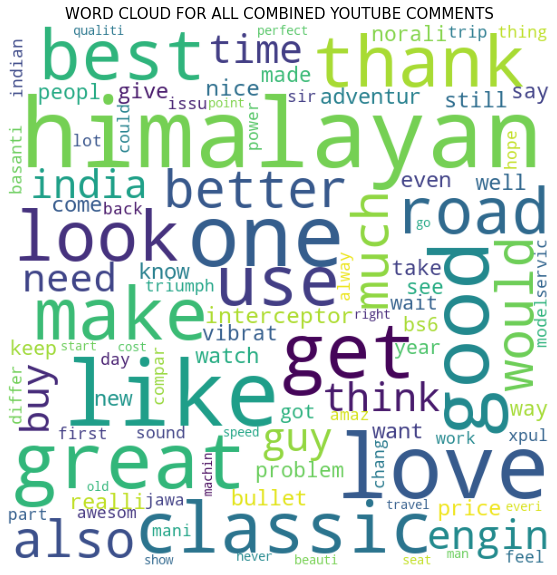

In [88]:
clouds = get_wordcloud(all_yt_comments)
plt.figure(figsize=(15,10))
plt.title("WORD CLOUD FOR ALL COMBINED YOUTUBE COMMENTS",fontsize=15)
plt.imshow(clouds)
plt.axis('off')
plt.show()

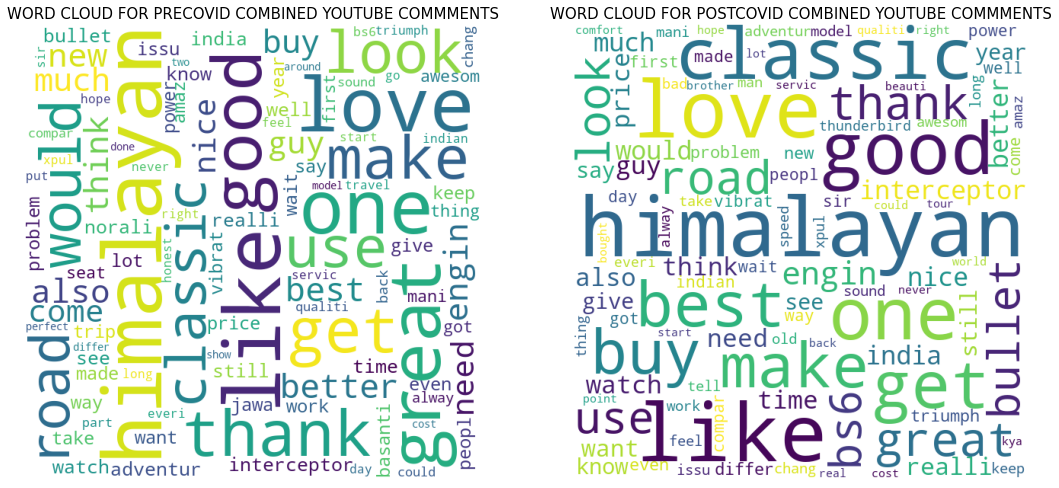

In [89]:
clouds = [get_wordcloud(pre_covid_yt_comments),get_wordcloud(post_covid_yt_comments)]
fig,axes = plt.subplots(1,2,figsize=(18,15))
for i in range(len(clouds)):
    axes[i].set_title("WORD CLOUD FOR "+periods[i].upper()+" COMBINED YOUTUBE COMMMENTS",fontsize=15)
    axes[i].imshow(clouds[i])
    axes[i].axis('off')